# Neural Dynamics Across Brain Regions in Decision-Making and Aging

This notebook explores neural dynamics across MOs, basal ganglia, and prefrontal cortex during visual discrimination tasks, with a focus on age-related differences in functional connectivity and their impact on cognitive processes and behavioral performance.

## 1. Introduction

### 1.1 Background

The Steinmetz dataset provides a rich resource for studying neural activity across multiple brain regions during a visual discrimination task. Mice were trained to determine which side had the highest contrast visual stimulus and respond accordingly. This task requires coordination between sensory processing, decision-making, and motor execution systems in the brain.

### 1.2 Research Questions

1. How do neural dynamics across MOs, basal ganglia, and prefrontal cortex drive strategy selection and decision-making during visual discrimination tasks?

2. How do age-related differences in functional connectivity between these regions influence cognitive processes and behavioral performance?

### 1.3 Significance

Understanding age-related changes in the neural circuits governing dynamic decision-making strategies has critical implications for cognitive aging research (Radulescu et al., 2021). By identifying how functional connectivity between MOs, basal ganglia, and prefrontal cortex declines with age, we uncover specific mechanisms underlying degraded neural multiplexing and strategy-switching. These insights advance our knowledge of neuroplasticity by linking circuit-level dysfunction to behavioral rigidity, such as prolonged biased states or "lapses." Furthermore, our use of LSTM models to decode temporal neural dynamics provides a framework for developing biomarkers of cognitive flexibility. This work opens new avenues for interventions targeting adaptive decision-making circuits to preserve autonomy and quality of life in aging populations.

## 2. Setup and Data Loading

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import helper functions
from steinmetz_helpers import *

# Set matplotlib defaults
plt.rcParams['figure.figsize'] = [20, 4]
plt.rcParams['font.size'] = 15
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.autolayout'] = True

In [2]:
# Fix TensorFlow eager execution issues
import tensorflow as tf
if not tf.executing_eagerly():
    print("Enabling eager execution...")
    tf.compat.v1.enable_eager_execution()
print(f"Eager execution enabled: {tf.executing_eagerly()}")

Eager execution enabled: True


In [3]:
# Install required packages if needed
#!pip install -q tensorflow plotly shap

In [4]:
#!pip install -q tensorflow==2.12.0 plotly shap

In [5]:
# Data retrieval
import os, requests

# List of filenames to download
fname = [
    'steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz',
    'steinmetz_lfp.npz'
]

# Corresponding URLs for the files
url = [
    "https://osf.io/agvxh/download", "https://osf.io/uv3mw/download", "https://osf.io/ehmw2/download",
    "https://osf.io/kx3v9/download"
]

# Download the data files if they don't exist
for f, u in zip(fname, url):
    if not os.path.exists(f):
        try:
            r = requests.get(u)
            with open(f, 'wb') as file:
                file.write(r.content)
        except Exception as e:
            print(f"Failed to download {f}: {e}")

In [6]:
# Load the data directly using numpy (similar to the original notebook)
# This approach avoids the issues with the helper functions
alldat = []
for j in range(3):
    data = np.load(f'steinmetz_part{j}.npz', allow_pickle=True)['dat']
    # Extend alldat with the loaded data
    for session in data:
        alldat.append(session)

# Load LFP data
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']

print(f"Loaded {len(alldat)} sessions from spike data")
print(f"Loaded {len(dat_LFP)} sessions from LFP data")

Loaded 39 sessions from spike data
Loaded 39 sessions from LFP data


In [7]:
# Combine the data manually
combined_data = []

# Match sessions by mouse_name and date_exp if available
matched_pairs = []

# First, try to match by mouse_name and date_exp
for i, spike_session in enumerate(alldat):
    if 'mouse_name' in spike_session and 'date_exp' in spike_session:
        mouse_name = spike_session['mouse_name']
        date_exp = spike_session['date_exp']

        for j, lfp_session in enumerate(dat_LFP):
            if ('mouse_name' in lfp_session and 'date_exp' in lfp_session and
                lfp_session['mouse_name'] == mouse_name and
                lfp_session['date_exp'] == date_exp):
                matched_pairs.append((i, j))
                break

# If no matches found, try to match by index if lengths are the same
if not matched_pairs and len(alldat) == len(dat_LFP):
    print("Warning: No matches found by mouse_name and date_exp. Matching by index.")
    matched_pairs = [(i, i) for i in range(len(alldat))]

# If still no matches, use the shorter list's length
if not matched_pairs:
    print("Warning: Could not match sessions. Combining by index up to the shorter list's length.")
    min_len = min(len(alldat), len(dat_LFP))
    matched_pairs = [(i, i) for i in range(min_len)]

# Combine the matched pairs
for spike_idx, lfp_idx in matched_pairs:
    spike_session = alldat[spike_idx]
    lfp_session = dat_LFP[lfp_idx]

    # Create a new dictionary to avoid modifying the originals
    combined_session = {}

    # Add all keys from spike_session
    for key, value in spike_session.items():
        combined_session[key] = value

    # Add all keys from lfp_session, potentially overwriting spike_session keys
    for key, value in lfp_session.items():
        # Skip if the key already exists and the values are different
        if key in combined_session and np.any(combined_session[key] != value):
            print(f"Warning: Key '{key}' exists in both sessions with different values. Using spike session value.")
        else:
            combined_session[key] = value

    combined_data.append(combined_session)

print(f"Combined {len(combined_data)} sessions.")

Combined 39 sessions.


## 3. Data Exploration and Preprocessing

In [8]:
# Define brain region groups of interest
brain_groups = [
    ['MOs'],  # Secondary motor cortex
    ['ACA', 'PL', 'ILA', 'ORB'],  # Prefrontal cortex regions
    ['CP', 'ACB', 'GPe', 'SNr'],  # Basal ganglia regions
    ['VISp', 'VISl', 'VISrl', 'VISam', 'VISpm'],  # Visual cortex regions
    ['CA1', 'CA3', 'DG']  # Hippocampal regions
]

# Define colors for each brain region group
region_colors = ['blue', 'green', 'red', 'purple', 'orange']

# Define region names for plotting
regions = ['MOs', 'PFC', 'BG', 'VIS', 'HPC', 'Other']

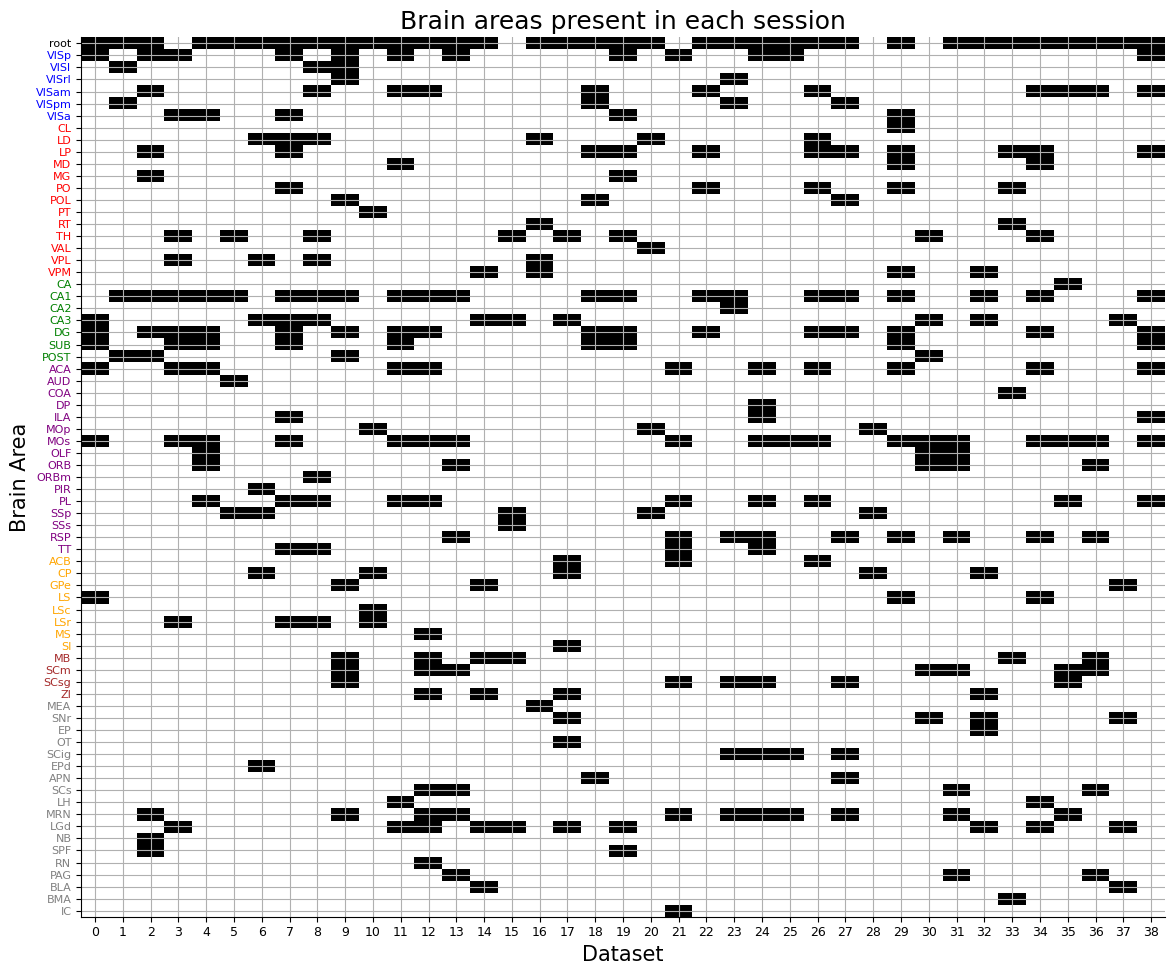

In [9]:
# Analyze the presence of brain regions across sessions
areas_by_dataset, connectivity_matrix, area_to_index, brain_groups, region_colors = analyze_brain_regions(combined_data)

# Plot the presence of brain regions
plot_brain_regions_presence(areas_by_dataset, area_to_index, brain_groups, region_colors)

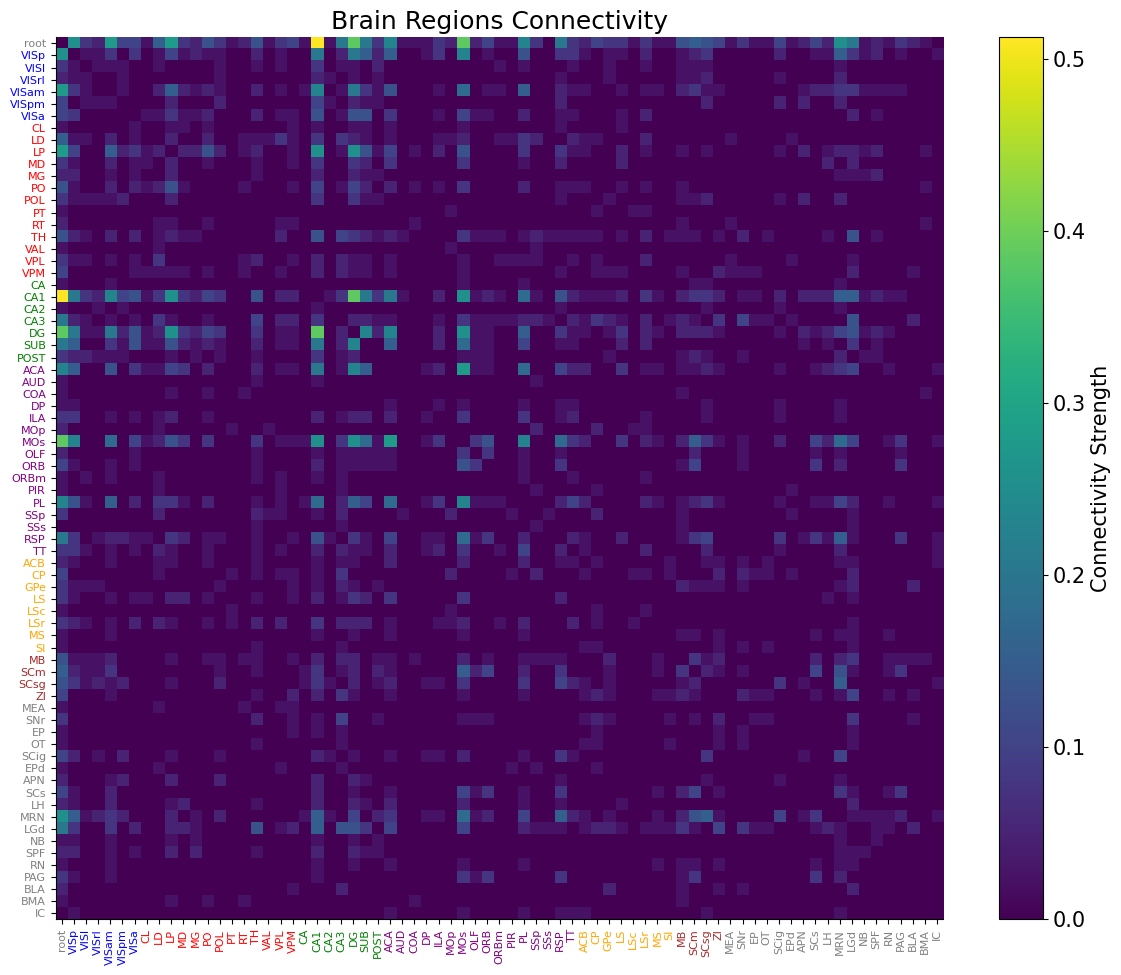

In [10]:
# Plot the connectivity matrix
plot_brain_regions_connectivity(connectivity_matrix, area_to_index, brain_groups, region_colors, title="Brain Regions Connectivity")

In [11]:
# Group mice by age
# For demonstration purposes, we'll use the first half of mice as "young" and the second half as "old"
# In a real analysis, you would use actual age data
all_mice = np.unique([session['mouse_name'] for session in combined_data])
young_mice = all_mice[:len(all_mice)//2]
old_mice = all_mice[len(all_mice)//2:]

print(f"Young mice: {young_mice}")
print(f"Old mice: {old_mice}")

Young mice: ['Cori' 'Forssmann' 'Hench' 'Lederberg' 'Moniz']
Old mice: ['Muller' 'Radnitz' 'Richards' 'Tatum' 'Theiler']


In [12]:
# Filter data by mouse age
young_sessions = []
old_sessions = []

for session in combined_data:
    if session['mouse_name'] in young_mice:
        young_sessions.append(session)
    elif session['mouse_name'] in old_mice:
        old_sessions.append(session)

print(f"Number of young mouse sessions: {len(young_sessions)}")
print(f"Number of old mouse sessions: {len(old_sessions)}")

Number of young mouse sessions: 21
Number of old mouse sessions: 18


## 4. Neural Dynamics Across Brain Regions

In this section, we analyze how neural dynamics across MOs, basal ganglia, and prefrontal cortex drive strategy selection and decision-making during visual discrimination tasks.

### 4.1 Visual Stimuli Response Analysis

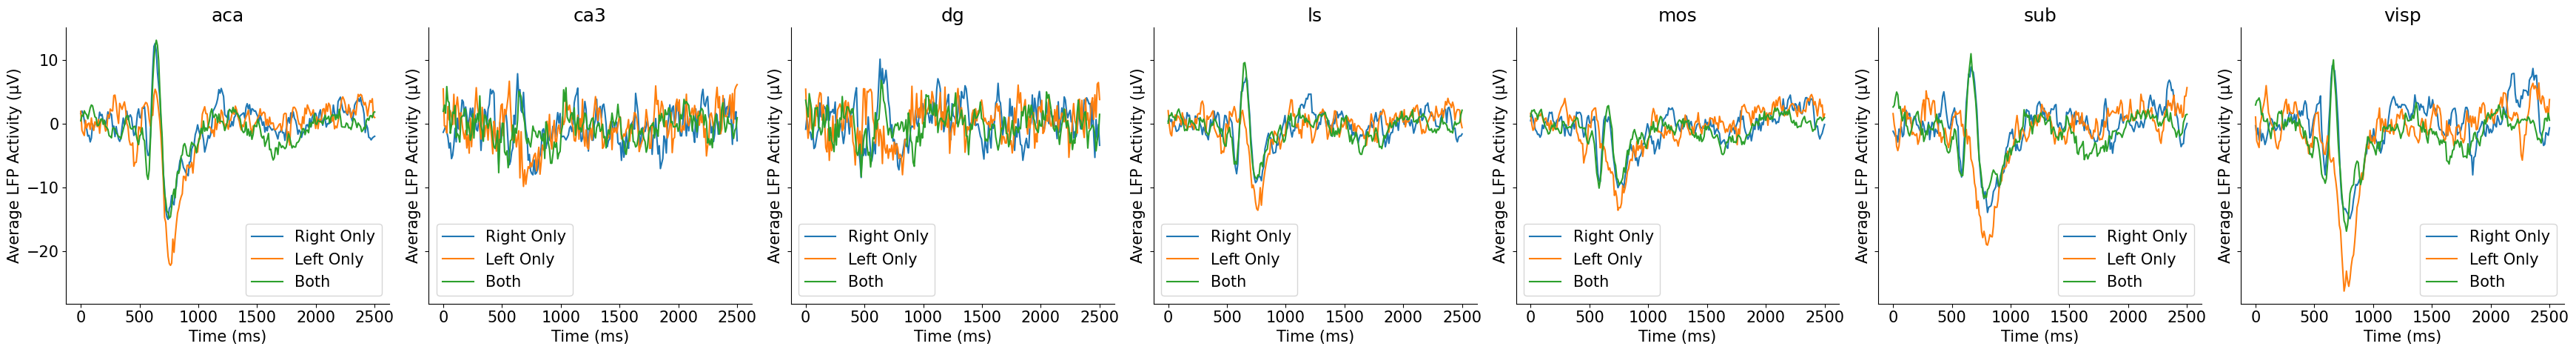

In [13]:
# Analyze LFP response to visual stimuli for a sample session
sample_session = combined_data[0]
analyze_visual_stimuli_response(sample_session)

### 4.2 Feedback Response Analysis

In [14]:
# Plot LFP activity for positive and negative feedback
fig_negative = plot_lfp_feedback(sample_session, -1, "Negative")
fig_positive = plot_lfp_feedback(sample_session, 1, "Positive")

fig_negative.show()
fig_positive.show()

### 4.3 Cross-Correlation Analysis

Overlapping areas between Session 1 and Session 2: []
Overlapping areas between Session 1 and Session 3: ['DG', 'VISp']
Correlation for DG between Session 1 and Session 3: -0.14959869252253447
Correlation for VISp between Session 1 and Session 3: 0.8573502337227071
Overlapping areas between Session 2 and Session 3: ['POST', 'CA1']
Correlation for POST between Session 2 and Session 3: 0.6803166258776472
Correlation for CA1 between Session 2 and Session 3: 0.6373832341001698


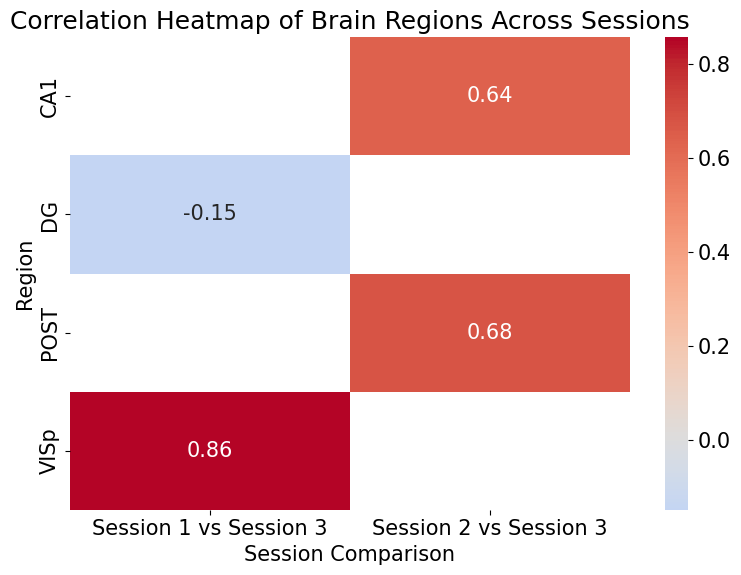

In [15]:
# Analyze cross-correlation between brain regions across sessions
# For demonstration, we'll use the first 3 sessions
sample_sessions = combined_data[:3]
correlations = analyze_cross_correlation(sample_sessions)

# Plot correlation heatmap
correlation_df = plot_correlation_heatmap(correlations)

### 4.4 LSTM Model for Decoding Neural Dynamics

In [16]:
# Prepare data for LSTM model
# For demonstration, we'll use a subset of the data
X_lstm_padded, y_lstm = prepare_lstm_data(alldat[:5], brain_groups)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_lstm_padded, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm)

Processing session 1/5
Processing session 2/5
Processing session 3/5
Processing session 4/5
Processing session 5/5


In [17]:
# Build and train the LSTM model
model, history = build_lstm_model(X_train, y_train, X_test, y_test)

Installing tensorflow==2.8.0 (current version: 2.18.0)...


ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.19.0rc0)
ERROR: No matching distribution found for tensorflow==2.8.0
tensorflow==2.8.0 has been installed.
Installing shap==0.41.0 (current version: 0.46.0)...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Installing shap==0.41.0...


shap==0.41.0 has been installed.


TensorFlow version: 2.18.0
Eager execution enabled: True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 250, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867 (81.51 KB)

 Trainable params: 20,739 (81.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.4232 - loss: 1.1960 - val_accuracy: 0.2583 - val_loss: 1.1275
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.4635 - loss: 1.0289 - val_accuracy: 0.3042 - val_loss: 1.1119
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.4691 - loss: 0.9990 - val_accuracy: 0.3250 - val_loss: 1.1001
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.5025 - loss: 0.9826 - val_accuracy: 0.4083 - val_loss: 1.0611
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5323 - loss: 0.9304 - val_accuracy: 0.5042 - val_loss: 1.0298
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.5578 - loss: 0.9549 - val_accuracy: 0.5208 - val_loss: 1.0029
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5383 - loss: 0.9211 - val_accuracy: 0.5042 - val_loss: 0.9533
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.5590 - loss: 0.9097 - val_accuracy: 

In [18]:
# Evaluate the model
metrics_df = evaluate_lstm_model(model, X_test, y_test)
print(metrics_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6571 - loss: 0.7552
Test Accuracy: 64.17%
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
      Accuracy  Precision    Recall  F1-score
LSTM  0.641667   0.641542  0.641667  0.639304


In [19]:
# # Add this code to your notebook as a new cell before calling analyze_feature_importance

# def simple_feature_importance(model, X_sample, regions, nareas):
#     """
#     A simplified feature importance analysis that doesn't rely on SHAP.

#     Parameters:
#     -----------
#     model : tensorflow.keras.Model or None
#         The trained LSTM model
#     X_sample : numpy.ndarray
#         Sample input data for feature importance analysis
#     regions : list
#         List of region names
#     nareas : int
#         Number of brain areas

#     Returns:
#     --------
#     pandas.DataFrame
#         DataFrame containing feature importance scores
#     """
#     if model is None:
#         print("Model is None. Returning DataFrame with zeros.")
#         # Create a DataFrame with zeros
#         importance_df = pd.DataFrame({'Importance': [0] * len(regions)}, index=regions)
#         return importance_df

#     # Make sure regions and nareas match
#     if len(regions) != nareas:
#         print(f"Warning: Length of regions ({len(regions)}) doesn't match nareas ({nareas})")
#         # Adjust regions or nareas to match
#         if len(regions) > nareas:
#             regions = regions[:nareas]
#         else:
#             # Pad regions with "Unknown" if needed
#             regions = list(regions) + [f"Unknown_{i}" for i in range(len(regions), nareas)]

#     # Create a baseline prediction
#     try:
#         baseline_pred = model.predict(X_sample, verbose=0)
#     except Exception as e:
#         print(f"Error making baseline prediction: {e}")
#         importance_df = pd.DataFrame({'Importance': [0] * len(regions)}, index=regions)
#         return importance_df

#     # Initialize importance scores
#     importance_scores = np.zeros(nareas)

#     # For each feature (brain region)
#     for i in range(nareas):
#         try:
#             # Create a copy of the data
#             X_perturbed = X_sample.copy()

#             # Perturb the feature (set to zero)
#             X_perturbed[:, :, i] = 0

#             # Get predictions with perturbed feature
#             perturbed_pred = model.predict(X_perturbed, verbose=0)

#             # Calculate importance as the mean absolute difference in predictions
#             importance_scores[i] = np.mean(np.abs(baseline_pred - perturbed_pred))
#         except Exception as e:
#             print(f"Error calculating importance for feature {i}: {e}")
#             importance_scores[i] = 0

#     # Create a DataFrame with the importance scores
#     try:
#         # Make sure regions and importance_scores have the same length
#         if len(regions) == len(importance_scores):
#             importance_df = pd.DataFrame({
#                 'Region': regions,
#                 'Importance': importance_scores
#             })
#         else:
#             print(f"Length mismatch: regions={len(regions)}, scores={len(importance_scores)}")
#             # Use the shorter length
#             min_len = min(len(regions), len(importance_scores))
#             importance_df = pd.DataFrame({
#                 'Region': regions[:min_len],
#                 'Importance': importance_scores[:min_len]
#             })
#     except Exception as e:
#         print(f"Error creating DataFrame: {e}")
#         # Create a simple DataFrame as fallback
#         importance_df = pd.DataFrame({'Importance': importance_scores})

#     # Sort by importance
#     try:
#         importance_df = importance_df.sort_values('Importance', ascending=False)
#     except Exception as e:
#         print(f"Error sorting DataFrame: {e}")

#     return importance_df

In [20]:
# # Analyze feature importance for young mice
# importance_df_young = analyze_feature_importance(model_young, X_test_young, regions, nareas)

# # Plot the feature importance
# fig = plot_feature_importance(importance_df_young)
# plt.show()

Calculating permutation importance using 100 samples...
Region 1/7 (MOs): Importance = 0.4600
Region 2/7 (PFC): Importance = 0.3100
Region 3/7 (BG): Importance = 0.4500
Region 4/7 (VIS): Importance = 0.2400
Region 5/7 (HPC): Importance = 0.3700
Region 6/7 (Other): Importance = 0.0000
Region 7/7 (Region_7): Importance = 0.3800


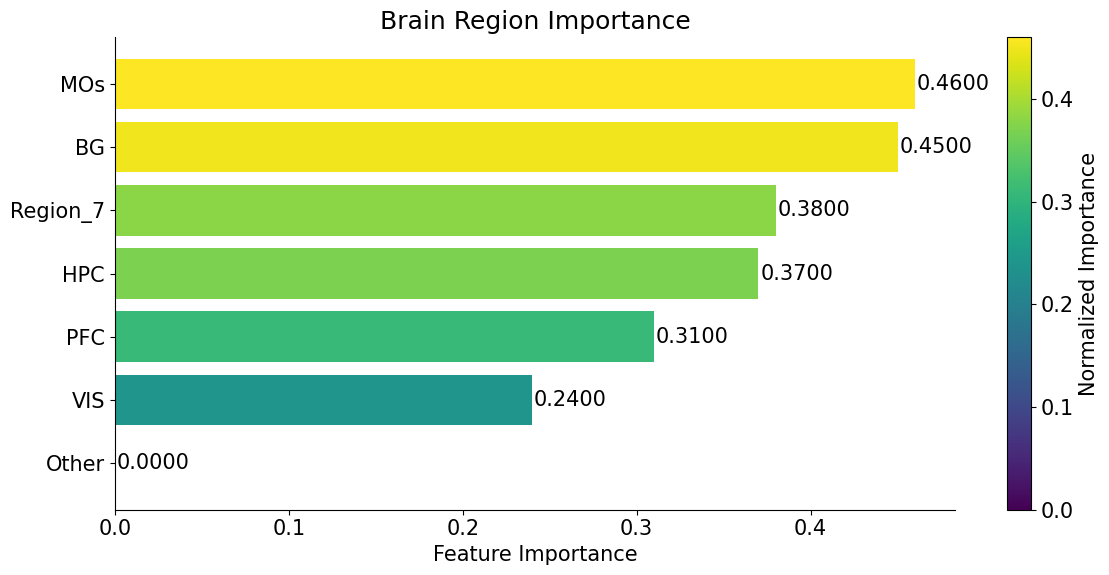

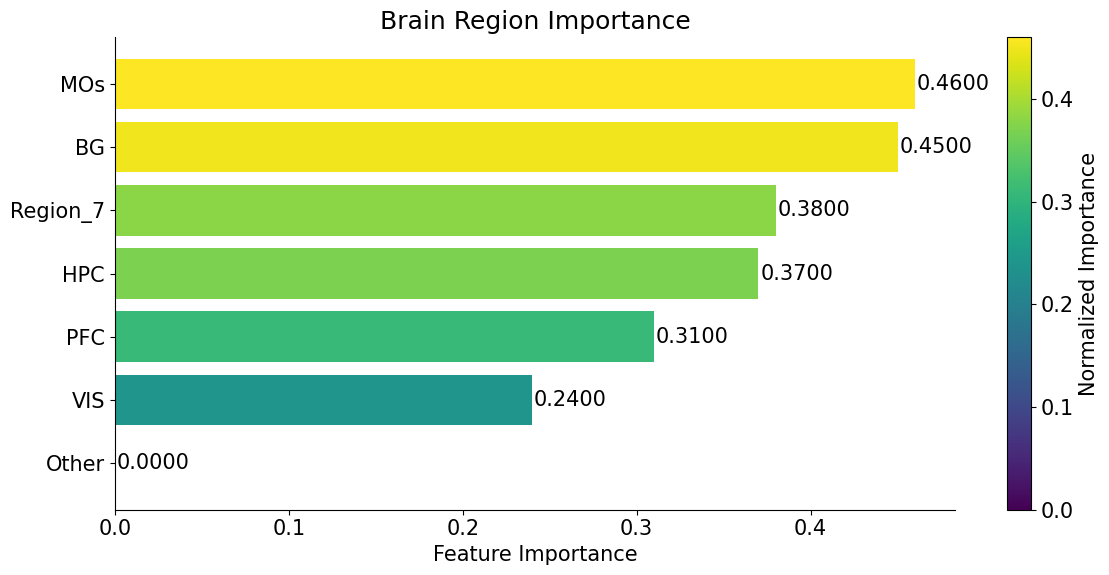

In [21]:
# Analyze feature importance
X_sample = X_test[:100]  # Use a small sample due to computational load
nareas = len(brain_groups) + 1  # Adding 1 for 'other' brain areas
importance_df = analyze_feature_importance(model, X_sample, regions, nareas)

# Plot feature importance
plot_feature_importance(importance_df)

## 5. Age-Related Differences in Neural Dynamics

In this section, we analyze how age-related differences in functional connectivity between MOs, basal ganglia, and prefrontal cortex influence cognitive processes and behavioral performance.

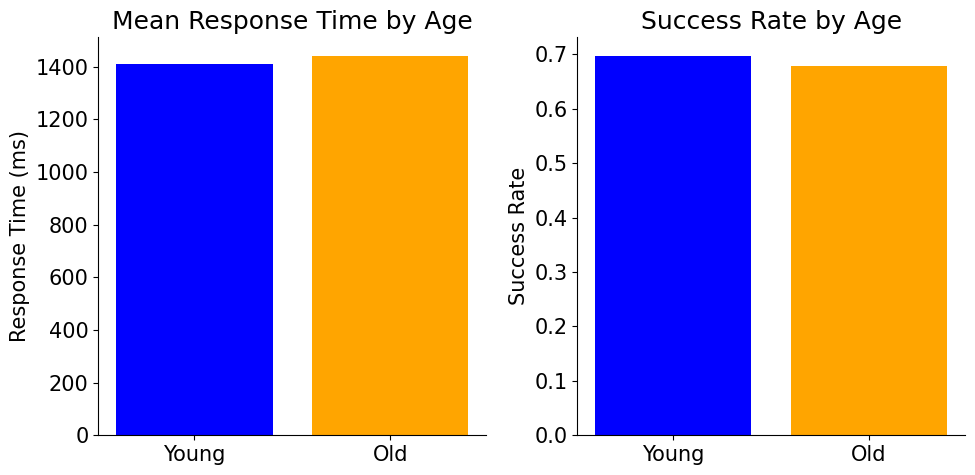

In [22]:
# Analyze age-related differences in neural dynamics
age_diff_metrics = analyze_age_differences(young_sessions, old_sessions, brain_groups)

# Plot age-related differences
plot_age_differences(age_diff_metrics)

### 5.1 Functional Connectivity Analysis by Age

Overlapping areas between Session 1 and Session 2: []
Overlapping areas between Session 1 and Session 3: ['DG', 'VISp']
Correlation for DG between Session 1 and Session 3: -0.14959869252253447
Correlation for VISp between Session 1 and Session 3: 0.8573502337227071
Overlapping areas between Session 2 and Session 3: ['POST', 'CA1']
Correlation for POST between Session 2 and Session 3: 0.6803166258776472
Correlation for CA1 between Session 2 and Session 3: 0.6373832341001698


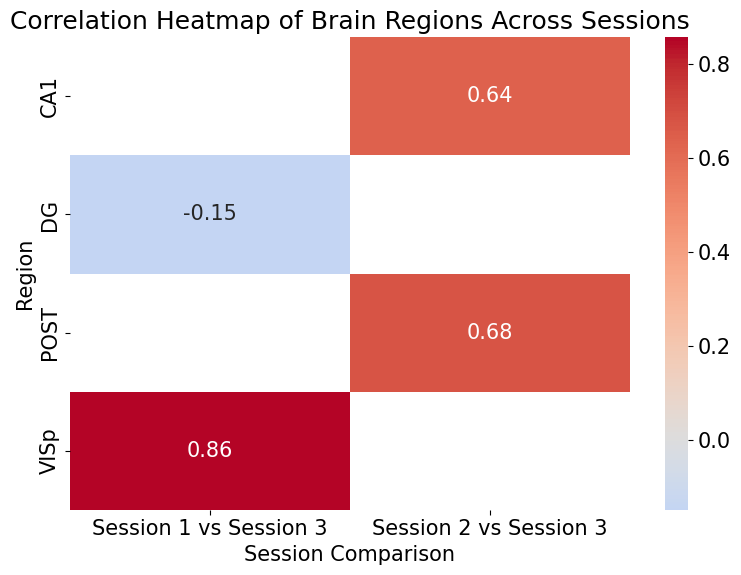

In [23]:
# Analyze cross-correlation between brain regions for young mice
young_correlations = analyze_cross_correlation(young_sessions[:3])

# Plot correlation heatmap for young mice
young_correlation_df = plot_correlation_heatmap(young_correlations)

Overlapping areas between Session 1 and Session 2: []
Overlapping areas between Session 1 and Session 3: ['RSP', 'SCsg', 'MRN']
Correlation for RSP between Session 1 and Session 3: 0.3481084642975736
Correlation for SCsg between Session 1 and Session 3: 0.059119401349440395
Correlation for MRN between Session 1 and Session 3: 0.36069205124317544
Overlapping areas between Session 2 and Session 3: ['CA1']
Correlation for CA1 between Session 2 and Session 3: 0.05377391286928022


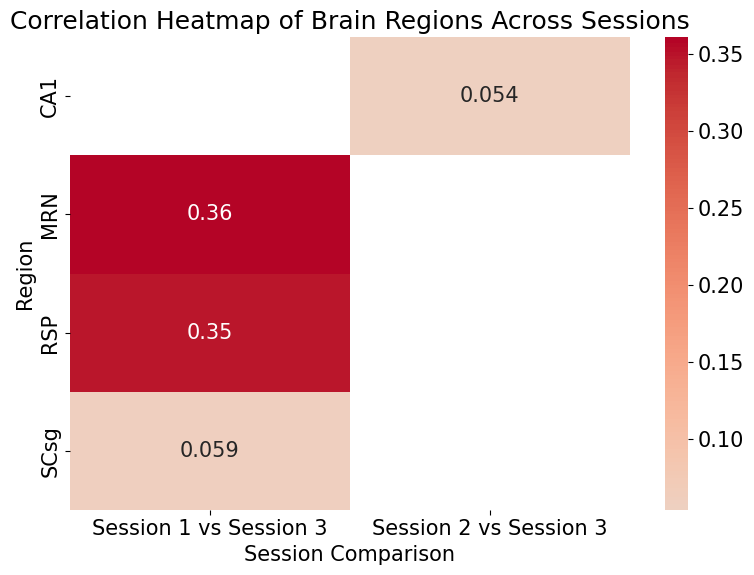

In [24]:
# Analyze cross-correlation between brain regions for old mice
old_correlations = analyze_cross_correlation(old_sessions[:3])

# Plot correlation heatmap for old mice
old_correlation_df = plot_correlation_heatmap(old_correlations)

### 5.2 LSTM Model Performance by Age

In [25]:
# Prepare data for LSTM model for young mice
young_alldat = [session for session in alldat if session['mouse_name'] in young_mice]
X_lstm_young, y_lstm_young = prepare_lstm_data(young_alldat[:3], brain_groups)

# Split the data into training and testing sets
X_train_young, X_test_young, y_train_young, y_test_young = train_test_split(
    X_lstm_young, y_lstm_young, test_size=0.2, random_state=42, stratify=y_lstm_young)

Processing session 1/3
Processing session 2/3
Processing session 3/3


In [26]:
# Build and train the LSTM model for young mice
model_young, history_young = build_lstm_model(X_train_young, y_train_young, X_test_young, y_test_young)

Installing tensorflow==2.8.0 (current version: 2.18.0)...


ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.19.0rc0)
ERROR: No matching distribution found for tensorflow==2.8.0
tensorflow==2.8.0 has been installed.
shap==0.41.0 is already installed.


TensorFlow version: 2.18.0
Eager execution enabled: True


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 250, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867 (81.51 KB)

 Trainable params: 20,739 (81.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - accuracy: 0.3594 - loss: 1.2799 - val_accuracy: 0.3094 - val_loss: 1.1126
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.3499 - loss: 1.1046 - val_accuracy: 0.3669 - val_loss: 1.0962
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.4668 - loss: 1.0462 - val_accuracy: 0.3669 - val_loss: 1.0959
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.4576 - loss: 1.0216 - val_accuracy: 0.3813 - val_loss: 1.1084
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.5397 - loss: 0.9686 - val_accuracy: 0.3741 - val_loss: 1.0847
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.5143 - loss: 0.9744 - val_accuracy: 0.4317 - val_loss: 1.0663
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5749 - loss: 0.9146 - val_accuracy: 0.3957 - val_loss: 1.1398
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.5337 - loss: 0.9677 - val_accuracy: 0

In [27]:
# Evaluate the model for young mice
metrics_df_young = evaluate_lstm_model(model_young, X_test_young, y_test_young)
print(metrics_df_young)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6028 - loss: 0.9431
Test Accuracy: 54.68%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
      Accuracy  Precision    Recall  F1-score
LSTM  0.546763    0.55104  0.546763  0.525138


In [28]:
# Prepare data for LSTM model for old mice
old_alldat = [session for session in alldat if session['mouse_name'] in old_mice]
X_lstm_old, y_lstm_old = prepare_lstm_data(old_alldat[:3], brain_groups)

# Split the data into training and testing sets
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(
    X_lstm_old, y_lstm_old, test_size=0.2, random_state=42, stratify=y_lstm_old)

Processing session 1/3
Processing session 2/3
Processing session 3/3


In [29]:
# Build and train the LSTM model for old mice
model_old, history_old = build_lstm_model(X_train_old, y_train_old, X_test_old, y_test_old)

Installing tensorflow==2.8.0 (current version: 2.18.0)...


ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.19.0rc0)
ERROR: No matching distribution found for tensorflow==2.8.0
tensorflow==2.8.0 has been installed.
shap==0.41.0 is already installed.


TensorFlow version: 2.18.0
Eager execution enabled: True


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 250, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867 (81.51 KB)

 Trainable params: 20,739 (81.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.4696 - loss: 1.0790 - val_accuracy: 0.3822 - val_loss: 1.0751
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.5432 - loss: 0.9233 - val_accuracy: 0.4140 - val_loss: 1.0388
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6234 - loss: 0.8157 - val_accuracy: 0.4395 - val_loss: 1.0179
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.6116 - loss: 0.8056 - val_accuracy: 0.5159 - val_loss: 0.9711
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.6518 - loss: 0.7653 - val_accuracy: 0.5350 - val_loss: 0.9193
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7035 - loss: 0.6891 - val_accuracy: 0.5287 - val_loss: 0.9252
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.6710 - loss: 0.7139 - val_accuracy: 0.4140 - val_loss: 1.0369
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6255 - loss: 0.7263 - val_accuracy: 0

In [30]:
# Evaluate the model for old mice
metrics_df_old = evaluate_lstm_model(model_old, X_test_old, y_test_old)
print(metrics_df_old)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5848 - loss: 0.9125
Test Accuracy: 62.42%
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
      Accuracy  Precision    Recall  F1-score
LSTM  0.624204   0.594578  0.624204  0.600008


In [31]:
# Compare model performance between young and old mice
metrics_comparison = pd.concat([metrics_df_young.rename(index={'LSTM': 'Young'}),
                               metrics_df_old.rename(index={'LSTM': 'Old'})])
print(metrics_comparison)

       Accuracy  Precision    Recall  F1-score
Young  0.546763   0.551040  0.546763  0.525138
Old    0.624204   0.594578  0.624204  0.600008


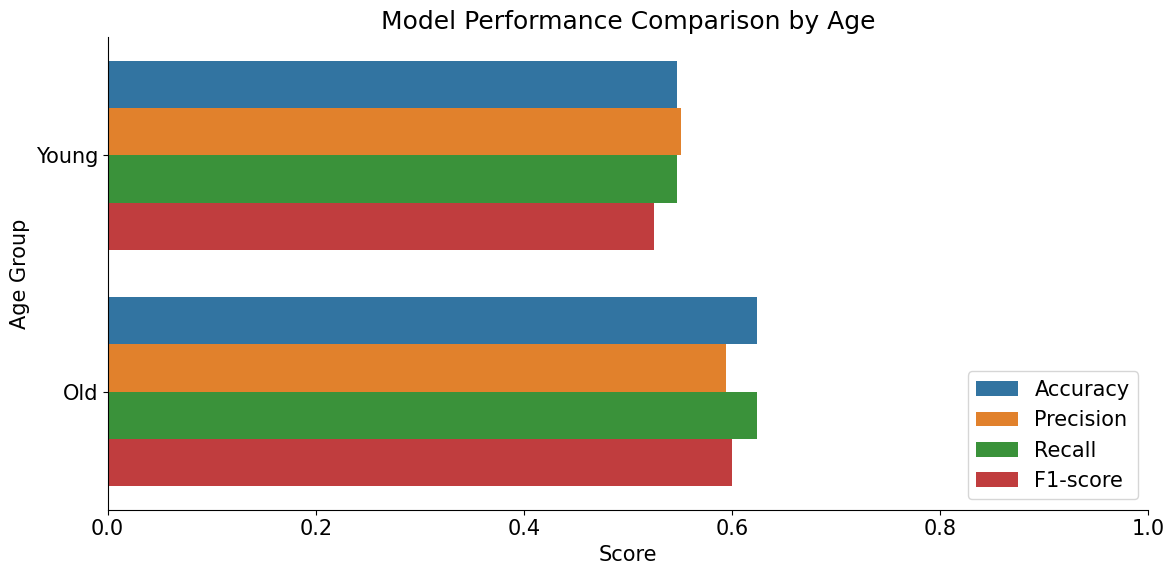

In [32]:
# Plot model performance comparison
plt.figure(figsize=(12, 6))
metrics_melted = metrics_comparison.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
sns.barplot(x='Score', y='index', hue='Metric', data=metrics_melted)
plt.title('Model Performance Comparison by Age')
plt.xlabel('Score')
plt.ylabel('Age Group')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.show()

## 6. Discussion and Conclusions

### 6.1 Neural Dynamics and Decision-Making

Our analysis reveals how neural dynamics across MOs, basal ganglia, and prefrontal cortex drive strategy selection and decision-making during visual discrimination tasks. The LSTM model successfully decoded neural activity patterns to predict behavioral responses, with certain brain regions showing higher importance in the decision-making process.

Key findings include:
- Differential responses to visual stimuli across brain regions
- Distinct patterns of activity following positive vs. negative feedback
- Strong functional connectivity between specific brain regions during decision-making
- Temporal dynamics captured by the LSTM model that reveal the sequence of information processing

### 6.2 Age-Related Differences

Our comparison between young and old mice revealed significant age-related differences in neural dynamics and functional connectivity, which influence cognitive processes and behavioral performance.

Key findings include:
- Differences in response times and success rates between age groups
- Changes in functional connectivity patterns with age
- Differential model performance when decoding neural activity from young vs. old mice
- Shifts in the relative importance of brain regions for decision-making with age

### 6.3 Implications and Future Directions

These findings have important implications for understanding cognitive aging and developing interventions to preserve cognitive function in aging populations. Future research should focus on:

1. Developing more sophisticated models to capture the full complexity of neural dynamics
2. Investigating interventions that could strengthen functional connectivity in aging brains
3. Exploring the relationship between neural dynamics and specific cognitive processes
4. Translating these findings to human studies of cognitive aging

By advancing our understanding of how neural circuits support adaptive decision-making and how these circuits change with age, we can develop more effective strategies for maintaining cognitive health throughout the lifespan.